4# Introduction #

In this tutorial, we will retrain the `EfficientDet-Lite` object detection model (derived from `EfficientDet`) using the TensorFlow Lite Model Maker library, and then compile it to run on the Coral Edge TPU. All in about 40 minutes. The Model Maker library uses transfer learning to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

By default, we'll retrain the model using a publicly available dataset of salad photos, teaching the model to recognize a salad and some of the ingredients. But we've also provided code so you can upload your own training dataset in the Pascal VOC XML format.

Here's an example of the salad training results:

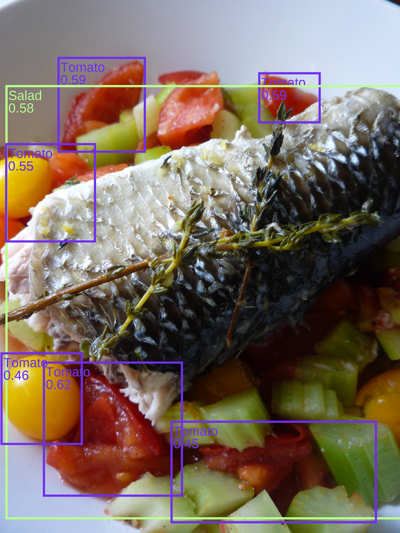

## Notes About This Tutorial ##
Some important notes to consider before embarking on this tutorial:
*   You should definitely run this notebook using a GPU runtime (a T4, L4, or A100 GPU runtime). If you choose a CPU-based runtime, your training will take f-o-r-e-v-e-r.
*   For this tutorial, you will need to upload and download files from the runtime. Before closing or disconnecting from your runtime, be sure to download and save any files (e.g., models) that are needed. Otherwise, they will be wiped and you will lose those files.
*   This tutorial was adapted from one originally provided by [Google](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_efficientdet_model_maker_tf2.ipynb). The old tutorial no longer works on Colab in its current state as Colab has upgraded the CUDA and Python versions on their hosted runtimes, which are incompatable with the EfficientDet retraining process described in the original notebook. I have adapted the original tutorial to allow students to retrain the EfficienDet model using the current Colab runtimes. I'll describe the gory details in case students are interested, but if not, you can simply skip past "The Gory Details."

### The Gory Details ###
So having Colab upgrading the Python and CUDA versions on the runtimes was really not cool because everything to do with TensorFlow Lite Model Maker essentially broke. Details of what exactly broke can be found in the discussion here: https://discuss.ai.google.dev/t/tflite-model-maker-installation/26927. You'll note that the solution as of May 2023 was to use Colab's "fallback runtime version" feature, which could allow Colab users to use an older version of the runtime containing older versions of Python and TensorFlow. Great news right? Wrong.

Google eliminated this feature sometime recently because it was working fine when I had my course developer retrain `EfficientDet` to test the feasibility of using the Coral USB Accelerator, but when we had 65 of these babies shipped to us, the feature suddenly dissappeared leaving us in a bit of a pickle.  

I wasn't worried then, because I had a solution: simply downgrade Python 3.9 and CUDA and then run the rest of the original notebook Note: this plan was quite solid as this is essentially what you're doing below. The only problem is, even after installing Python 3.9, Python 3.10 was used by default whenver you are running Python code in a cell. You can try this out yourself by running the code in a cell:

```
import sys
print(sys.version) # prints Python 3.10
```
Regardless of what I did, I could not get Colab to use Python 3.9 if I put Python code in a Colab cell. After, many hours, I noticed something interesting - if I typed in the following as a terminal command, I can actually get the desired result:

```
!python3 --version # prints Python 3.9
```

Interesting. This means that for some reason, when Python script is directly entered into a Colab cell, Python 3.10 is used; however, if Python script is run through the command line, then it uses Python 3.9. What this ultimately means is that all the code where a model is trained and evaluated using TensorFlow Lite needs to be in a `.py` file that is executed via the command line - and then it works. It isn't the best solution as you lose a lot of the markdown capabilities when you execute a script rather than code in a cell, but it beats not being able to train a model in Colab.

As of December 2025, I found a better solution - that is simply run everything through a virtual environment that is set up to have Python 3.9 as the default. Thus, this is what we do here.  

# Set up Virtual Environment #

TensorFlow Lite Model Maker is only compatible with Python 3.9. Unfortunately, Google Colab uses Python 3.10+. The solution to this issue is to run Google Colab using Python 3.9 using a [virtual environment](https://docs.python.org/3/library/venv.html). I'll explain what a virtual environment in a little bit.

## Install Miniconda ##
Here, we use [Miniconda](https://www.anaconda.com/docs/getting-started/miniconda/main), a distribution of Python, to help us create a Python 3.9 virtual environment.

The cell below downloads and installs Miniconda.

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
!conda update -y conda

## Create `myenv` Virtual Envrionment ##

The following cell activates Python virtual environment using the Miniconda. Python virtual environments (venvs) are isolated directories that allow developers to install and run specific versions of Python and its libraries without affecting the system-wide Python installation.

For example, suppose one of your projects that you are working on uses an older version of OpenCV, and another project uses a newer version. If you're working on both projects on the same machine, trying to work on one project and then switching to the other project may cause dependency conflicts around OpenCV. Having each project in its own venv allows the dependancies of each project to be completely isolated, eliminating such conflicts.

The cell below creates a conda virtual environment called `myenv` and installs Python 3.9 in this environment.



In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')
!conda create -y -n myenv python=3.9

## Check Python Version ##

This checks the python version to ensure that colab is running Python 3.9.

In [ ]:
! python3 --version

## Install Dependencies in `myenv` ##

The next lines install the following Python packages in our `myenv` environment:

*   [**tflite-model-maker**](https://pypi.org/project/tflite-model-maker/): needed for creating our training model
*   [**ipykernel**](https://pypi.org/project/ipykernel/): provides the Python interpreter kernel for Jupyter
*   [**numpy**](https://numpy.org/doc/stable/user/whatisnumpy.html): a library that provides tools for working with arrays and matrices
*   [**matplotlibb**](https://matplotlib.org/): a library for creating visualizations
*   [**pycocotools**](https://pypi.org/project/pycocotools/): containing the APIs of the [MS-COCO](https://cocodataset.org) dataset for reading and visualizing annotations

You don't really need to know the details of these packages, they are just dependancies that we need to run the rest of this retraining tutorial.

Note: Don't worry about the version errors that pop up regarding version compatibility of `matplotlib`.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

pip install tflite-model-maker
pip install ipykernel==5.5.6
pip install numpy==1.23.2
pip install matplotlib==3.7.5
pip install pycocotools==2.0.7

In the cell below, we will install NVidia `cuda` and `cudnn` that will allow us to use NVidia GPUs or TPUs for retraining our EfficientDet model.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

conda install -y -n base conda-libmamba-solver
conda install -y conda-forge::cudatoolkit==11.7.0 --solver=libmamba
conda install -y conda-forge::cudnn==8.9.7.29 --solver=libmamba


# Examining the Dataset #

You'll use the publicly available Salads dataset, which was created from the Open Images Dataset V4. We're going to download a copy of this dataset using the command below. Note: we won't be training on this copy of the salad dataset (as our training script will download its own copy) - we will only be downloading it to view the format of the data.

In [ ]:
! gsutil cp gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv /content/

Once you've run the above command, you will have downloaded a CSV file (CSV stands for "comma-seperated values"). To see this file, click on the file folder icon on the left hand side of Colab, as shown in the figure below, and click on double click on the salads_ml_use.csv file. This will open up a preview pane of the CSV file on the right hand side of the screen.

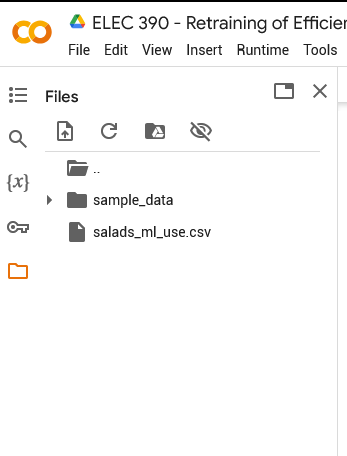

You'll notice that this dataset contains 1756 entries. It is not uncommon for datasets to be this size or larger. Let's take a look at the different columns of this `.csv` file. The first column contains the value TEST, TRAIN or VALIDATE. This denotes whether an entry should fall into the:

*   training set, the subset of data used to train the model by adjusting its parameters;
*   validation set used to evaluate the model's performance during training, helping to fine-tune the model's parameters and select the best-performing model; or,
*   test set which evaluate the final model's performance on unseen data, providing an unbiased evaluation of the model's accuracy in the real world.

The second column contains the Google Cloud address for a `.jpg` image. You'll note that the same jpg file may be used in more than one entry.

The third column is a label - e.g., "Cheese", "Tomato", "Salad", "Seafood", etc.

The forth and fifth, and eighth and ninth columns contain normalized (between 0 and 1) numbers: these describe two 2D points which describe the top left and bottom right coordinates of a bounding box corresponding to the label in the third column.

In summary, this dataset contains images that are presplit into different sets, containing labelled bounding boxes - where there may be multiple labels and bounding boxes per image.

# Train the Model #

For this step, you'll need to ensure that you have uploaded the `train_salad_model.py` file that is included on the ELEC 392 Course SharePoint to your runtime's folder. You can do this by simply dragging and dropping the file into the folder. Double click the Python file to examine the code. There are some comments that will help you with understanding what's going on under the hood.  

The next command will run the script and train the salad detector model. Training using a T4 GPU runtime will take approximately 40 minutes.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

export LD_LIBRARY_PATH=$CONDA_PREFIX/lib:$LD_LIBRARY_PATH
echo $LD_LIBRARY_PATH

python train_salad_model.py

You'll notice that a new file appears in your Colab's runtime directory: `efficientdet-lite-salad.tflite`. This is your TensorFlow model that will detect salad components!

# Testing the Model #
Let's test out the model ourselves with an image from the test set. To simplify our code, we'll use the [PyCoral API](https://www.coral.ai/docs/reference/py/) which we'll download using `pip`.

In [ ]:
INPUT_IMAGE = 'salad-test.jpg'
DOWNLOAD_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg"
!wget -q -O $INPUT_IMAGE $DOWNLOAD_URL

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral
pip install Pillow==9.5.0

Now let's run the script that will test our trained object detector on the test image we downloaded.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

python test_salad_model.py

In [ ]:
import os
import matplotlib.pyplot as plt
img = plt.imread('salad-detect-result.jpg')
plt.imshow(img)

## Compiling the TFLite Model for Edge TPU ##

Now that we have the TFLite model, it is possible to simply download it and run it off the Raspberry Pi. The problem is that the model won't run on the Edge TPU (Coral USB Accelerator). Instead, it will run off of the Pi's CPU, and detection will be incredibly slow - maybe a few frames per second if you're lucky.  

To run the model on the Edge TPU, we'll need to compile the model into a format that can be loaded on the Edge TPU. To do this, we will first need to download the Edge TPU Compiler:

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! apt update
! apt install edgetpu-compiler

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory.

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaeers](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models. We won't be using this in ELEC 392, as each team only has one Coral USB Accelerator.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model in case you wish to experiment with other models and have additional TPUs to share in future projects.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
NUMBER_OF_TPUS =  1

!edgetpu_compiler efficientdet-lite-salad.tflite -d --num_segments=$NUMBER_OF_TPUS

**Beware when using multiple segments:** The Edge TPU Comiler divides the model such that all segments have roughly equal amounts of parameter data, but that does not mean all segments have the same latency. Especially when dividing an SSD model such as EfficientDet, this results in a latency-imbalance between segments, because SSD models have a large post-processing op that actually executes on the CPU, not on the Edge TPU. So although segmenting your model this way is better than running the whole model on just one Edge TPU, we recommend that you segment the EfficientDet-Lite model using our [profiling-based partitioner tool](https://github.com/google-coral/libcoral/tree/master/coral/tools/partitioner#profiling-based-partitioner-for-the-edge-tpu-compiler), which measures each segment's latency on the Edge TPU and then iteratively adjusts the segmentation sizes to provide balanced latency between all segments.

# Download and Run the Models #

Alright, this last bit of Python code simply downloads the models that we trained to our computer, which we can transfer to our Raspberry Pi on-board the PiCar-X.

In [ ]:
from google.colab import files

files.download('efficientdet-lite-salad.tflite')
files.download('efficientdet-lite-salad_edgetpu.tflite')
files.download('salad-labels.txt')



You can now run the model with acceleration on the Edge TPU.

First, download an image of a salad on your device with an Edge TPU. For example, you can use the same one we tested above:

`wget https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg -O salad.jpg`

And then make sure you have installed the PyCoral API. If you installed the AIY Maker Image of Raspberry OS, you will have this installed already.

Now run an inference using this example code for the PyCoral API. Just clone the GitHub repo and run the example, passing it the model files from this tutorial:

```
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model efficientdet-lite-salads_edgetpu.tflite \
  --labels salad-labels.txt \
  --input salad.jpg \
  --output salad_result.jpg
```


## More resources ##

*   For more information about the Model Maker library used in this tutorial, see the TensorFlow Lite Model Maker guide and API reference.

*   For other transfer learning tutorials that are compatible with the Edge TPU, see the Colab tutorials for Coral.

*   You can also find more examples that show how to run inference on the Edge TPU at coral.ai/examples.
